In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import re
import os

In [2]:
output_file = 'Quad9.msh'

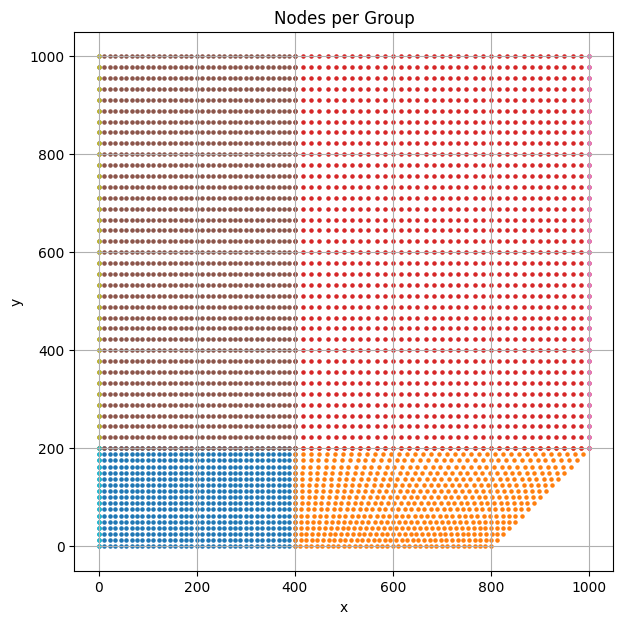

In [3]:
import meshio
import numpy as np
from collections import defaultdict
from nodes import Node  # Asegúrate que Node tenga `.index`, `.coord`, `.restrain` y `plot_nodes_por_grupo`

def make_nodes_groups_quad9(output_file, title):
    mesh = meshio.read(output_file)
    
    tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}
    grupos = defaultdict(dict)  # nombre_grupo: {id_nodo: Node}

    # Procesar elementos tipo quad9
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad9":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y])

    # Procesar líneas tipo line3 para condiciones de borde
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line3":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = [0, 0]
                if nombre == "Restriccion":
                    restrain = [1, 0]
                if np.isclose(x, 1000) and np.isclose(y, 1000):
                    restrain = [1, 1]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y], restrain=restrain)
                else:
                    grupos[nombre][node_id].restrain = restrain  # Actualiza si ya existe

    # Convertir a listas
    grupos_final = {nombre: list(nodos.values()) for nombre, nodos in grupos.items()}

    # Visualizar (si está disponible)
    Node.plot_nodes_por_grupo(grupos_final, title, show_ids=False, save=False)

    return grupos_final, mesh

grupos, mesh = make_nodes_groups_quad9(output_file, "Quad9")

In [4]:
from material import Material

class Membrane:
    def __init__(self, thickness, material):
        self.thickness = thickness
        self.material = material

def make_sections(grupos):
    thickness_dict = {"1": 100, "2": 100, "3": 100, "4": 100}
    sections = {}

    for group in thickness_dict:
        material = Material(E=200e3, nu=0.36, gamma=7800e-9)
        sections[group] = Membrane(thickness_dict[group], material)

    nodes_dict = {}
    for group in grupos:
        for node in grupos[group]:
            nodes_dict[node.index] = node

    return sections, nodes_dict

sections, nodes_dict = make_sections(grupos)


In [5]:
# Extrae el primer elemento tipo quad9
nodes_mesh = mesh.cells_dict['quad9'][0]

print("Nodos del primer Quad9:")
for i, node_id in enumerate(nodes_mesh):
    global_id = node_id + 1  # Node usa índices base 1
    coord = nodes_dict[global_id].coord
    print(f"  Nodo local {i}: ID global {global_id}, coordenadas = {coord}")


Nodos del primer Quad9:
  Nodo local 0: ID global 1, coordenadas = [np.float64(0.0), np.float64(0.0)]
  Nodo local 1: ID global 18, coordenadas = [np.float64(22.22222222222222), np.float64(0.0)]
  Nodo local 2: ID global 396, coordenadas = [np.float64(22.22222222222223), np.float64(25.0)]
  Nodo local 3: ID global 241, coordenadas = [np.float64(0.0), np.float64(25.0)]
  Nodo local 4: ID global 27, coordenadas = [np.float64(11.11111111111111), np.float64(0.0)]
  Nodo local 5: ID global 489, coordenadas = [np.float64(22.22222222222223), np.float64(12.5)]
  Nodo local 6: ID global 490, coordenadas = [np.float64(11.11111111111111), np.float64(25.0)]
  Nodo local 7: ID global 249, coordenadas = [np.float64(0.0), np.float64(12.5)]
  Nodo local 8: ID global 491, coordenadas = [np.float64(11.11111111111111), np.float64(12.5)]


In [6]:
from Quad2D import Quad9

def make_quad9_elements(mesh, sections, nodes_dict):
    quads = mesh.cells_dict.get('quad9', [])
    tags = mesh.cell_data_dict["gmsh:physical"].get("quad9", [])
    elements = []
    used_nodes = set()
    nodos_faltantes = []
    errores_jacobiano = []

    for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in sections:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i + 1} omitido.")
            continue

        section = sections[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            used_nodes.add(nodo)

        # Intentamos crear el elemento y capturamos errores de Jacobiano
        try:
            element = Quad9(i + 1, nodos, section)
            elements.append(element)
        except ValueError as ve:
            print(f"❌ Error en el elemento {i + 1} con Jacobiano no positivo:")
            print(f"   Nodos: {[n.index for n in nodos]}")
            print(f"   Coordenadas:")
            for j, n in enumerate(nodos):
                print(f"     Nodo local {j}: ID {n.index}, coord = {n.coord}")
            errores_jacobiano.append(i + 1)
            continue

    if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")
    if errores_jacobiano:
        print(f"⚠️ Se omitieron {len(errores_jacobiano)} elementos por Jacobiano negativo.")

    return elements, list(used_nodes)


# Uso:
elements, used_nodes = make_quad9_elements(mesh, sections, nodes_dict)


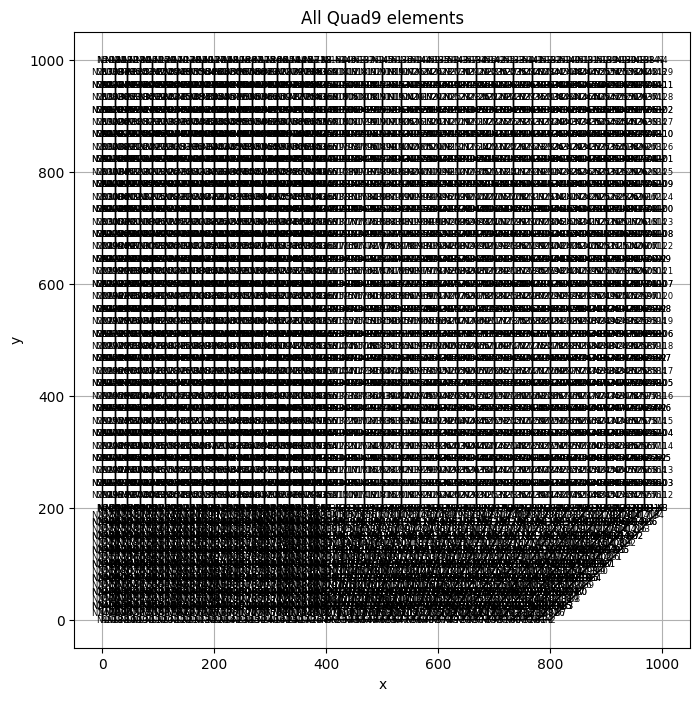

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_elements_quad9(elements, title, show_ids=True):
    all_x = []
    all_y = []

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Solo usar nodos de esquina para el contorno (0, 1, 2, 3, 0)
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        
        all_x.extend(coords_border[:, 0])
        all_y.extend(coords_border[:, 1])

    # Márgenes y dimensiones
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin

    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))

    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Dibujar contorno con nodos de esquina
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        ax.plot(coords_border[:, 0], coords_border[:, 1], 'k-', linewidth=1)

        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords):
                ax.text(x, y, f'N{nodo.index}', color='black', fontsize=6, ha='center', va='center')

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)

    plt.show()

# Uso:
plot_all_elements_quad9(elements, "All Quad9 elements", show_ids=True)


In [8]:
from solve import Solve

estructure = Solve(used_nodes, elements)



In [9]:
def apply_distributed_force_x(grupo_nodos, fuerza_total_x, estructura):
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Calcular posiciones acumuladas según distancia entre nodos (longitud sobre la curva)
    posiciones = [0.0]
    for i in range(1, n):
        dx = nodos[i].coord[0] - nodos[i-1].coord[0]
        dy = nodos[i].coord[1] - nodos[i-1].coord[1]
        distancia = np.sqrt(dx**2 + dy**2)
        posiciones.append(posiciones[-1] + distancia)
    total_longitud = posiciones[-1]

    # Inicializar fuerzas nodales
    nodal_forces = {}

    # Aplicar fuerza proporcional al tramo entre posiciones adyacentes
    for i in range(n):
        if i == 0:
            # Primer nodo: mitad de la diferencia con siguiente nodo
            fuerza = (posiciones[1] - posiciones[0]) / total_longitud * fuerza_total_x * 0.5
        elif i == n-1:
            # Último nodo: mitad de la diferencia con nodo anterior
            fuerza = (posiciones[-1] - posiciones[-2]) / total_longitud * fuerza_total_x * 0.5
        else:
            # Nodo interno: mitad de tramo anterior + mitad de tramo siguiente
            fuerza = ((posiciones[i] - posiciones[i-1]) + (posiciones[i+1] - posiciones[i])) / total_longitud * fuerza_total_x * 0.5
        nodal_forces[nodos[i].index] = fuerza

    # Aplicar fuerzas en X
    for node in nodos:
        fx = nodal_forces[node.index]
        dof_x, dof_y = node.dofs
        estructura.apply_force(dof_x, fx)
        estructura.apply_force(dof_y, 0.0)
        print(f"Nodo {node.index} ← Fx = {fx:.3f} N, Fy = 0.000 N, coordenadas y = {node.coord[1]:.3f}")

nodos_fuerza = grupos["Fuerza_Y_1"]  # O el grupo que corresponda
apply_distributed_force_x(nodos_fuerza, fuerza_total_x=-1000, estructura=estructure)
nodos_fuerza = grupos["Fuerza_Y_2"]  # O el grupo que corresponda
apply_distributed_force_x(nodos_fuerza, fuerza_total_x=-1000, estructura=estructure)


Nodo 5 ← Fx = -14.085 N, Fy = 0.000 N, coordenadas y = 1000.000
Nodo 208 ← Fx = -21.127 N, Fy = 0.000 N, coordenadas y = 955.556
Nodo 217 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 977.778
Nodo 200 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 911.111
Nodo 218 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 933.333
Nodo 209 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 866.667
Nodo 219 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 888.889
Nodo 201 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 822.222
Nodo 220 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 844.444
Nodo 210 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 777.778
Nodo 221 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 800.000
Nodo 202 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 733.333
Nodo 222 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 755.556
Nodo 211 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 688.889
Nodo 223 ← Fx = -28.169 N, Fy = 0.000 N, coordenadas y = 711.111
Nodo 203 ← Fx = -28.169 N,

In [10]:
desplazamientos = estructure.solve()

🔧 Ensamblando matriz global...
DOFs used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), 

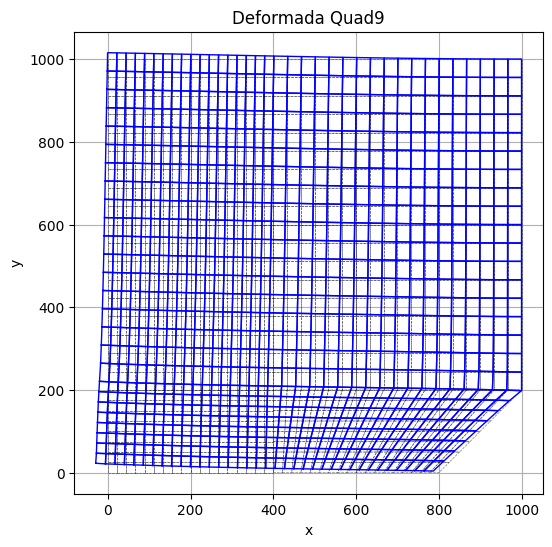

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_structure_quad9(elements, u_global, scale=1.0, show_original=True, title="Deformada"):
    """
    Grafica la estructura deformada para elementos Quad9.

    Args:
        elements (list): Lista de elementos Quad9.
        u_global (ndarray): Vector global de desplazamientos.
        scale (float): Factor de escala para deformación visual.
        show_original (bool): Muestra la geometría original si es True.
        title (str): Título del gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')

    for elem in elements:
        xy = elem.xy  # (9, 2)
        # Contorno sólo con nodos esquina (0,1,2,3,0)
        corner_indices = [0, 1, 2, 3, 0]
        coords = xy[corner_indices]

        if show_original:
            ax.plot(coords[:, 0], coords[:, 1], 'k--', linewidth=0.5, alpha=0.5)

        idx = elem.calculate_indices()
        u_elem = u_global[idx].flatten()
        xy_def = xy + scale * u_elem.reshape(-1, 2)
        coords_def = xy_def[corner_indices]

        ax.plot(coords_def[:, 0], coords_def[:, 1], 'b-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)
    plt.show()

# Uso:
plot_deformed_structure_quad9(elements, desplazamientos, scale=1e5, show_original=True, title="Deformada Quad9")


In [12]:
from graph import plot_results
plot_results(
    estructure,
    elements,
    title="mi_estructura",
    def_scale=500000,
    force_scale=1,
    reaction_scale=1e-2,
    sigma_y_tension=250, 
    sigma_y_compression=250
)

📌 Sumatoria total de reacciones: Rx = 2000.000 N, Ry = 0.000 N, ||R|| = 2000.000 N
🔧 Mínimo FS Tracción: 2557.201
🔧 Mínimo FS Compresión: 6940.750
